# Hate Detection Procedure

## Part 1: Preparing environment and data

### Readying dependencies

In [ ]:
pip install -r requirements.txt

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\My
[nltk_data]     Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocessing

In [3]:
## Loading data
data = pd.read_csv("Dynamically Generated Hate Dataset v0.2.3.csv")
data.head()

,Unnamed: 0,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
0,1,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
1,2,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
2,3,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN
3,4,acl1000,4,I'm not saying we should actually eliminate he...,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN
4,5,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN


In [49]:
## Getting Texts
text_data = data['text']
text_data[:5]

0                                  dalits are lowlives
1               gay people are a burden to our society
2                                Arabs are not welcome
3    I'm not saying we should actually eliminate he...
4                         bananas are for black people
Name: text, dtype: object

In [9]:
## Getting labels for hate and nothate
label_data = data['label']
label_data[:5]

0    hate
1    hate
2    hate
3    hate
4    hate
Name: label, dtype: object

In [32]:
## Checking number of classes for imbalance
label_data.value_counts()

label
hate       22175
nothate    18969
Name: count, dtype: int64

In [108]:
## converting labels to nothate = 0 and hate = 1    
def convert_labels(label):
    if label == "hate": return 1
    elif label == "nothate": return 0
    else: raise Exception("WRONG LABEL")

clean_label_data = label_data.apply(lambda x: convert_labels(x))

In [109]:

clean_label_data[:5]

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

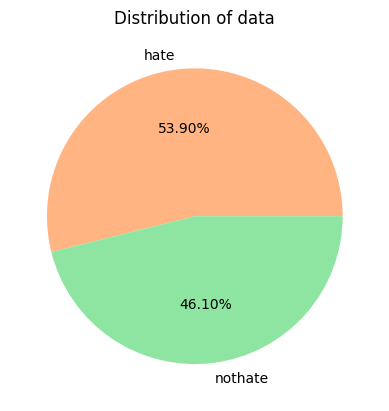

In [41]:
##  Visualizing distribution of data
colors = sns.color_palette('pastel')[1:3]
values = label_data.value_counts().values
labels = label_data.value_counts().index
plt.pie(x=values, labels=labels, colors=colors, autopct='%.2f%%')
plt.title("Distribution of data")
plt.show()

In [133]:
## Function to remove stopwords from sentences
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    temp = ' '.join([word for word in text.split() if word not in stop_words])
    return temp

## Function to remove special characters from sentences
def remove_special(text):
    special_char = ['%','$','#','@','^','_','*','?',';',':','.',',',"'"]
    for char in special_char:
        text = text.replace(char,'')
    return text

clean_text_data = text_data.apply(lambda x: remove_special(x)).apply(lambda x: remove_stopwords(x))

In [134]:
clean_text_data[:5]

0                                      dalits lowlives
1                            gay people burden society
2                                        Arabs welcome
3    Im saying actually eliminate heebs I wish natu...
4                                 bananas black people
Name: text, dtype: object

In [135]:
clean_text_data

'Im saying actually eliminate heebs I wish naturally became extinct'

In [141]:
## Longest word in data
longest_data = len(max(clean_text_data).split())
print("# of words in longest data point:", longest_data)

# of words in longest data point: 10


## Part 2: Machine Learning Development

### Creating Train and Test sets

In [142]:
## Splitting train and test data
train_X, test_X, train_y, test_y = train_test_split(clean_text_data,    # x data                                       
                                                    clean_label_data,   # y data
                                                    test_size=0.2,      #in percentage
                                                    random_state = 42   #for reproducibility
                                                    )

In [143]:
## Showing size of training and test data
print("Number of training data: ", len(train_x))
print("Number of test data: ", len(test_x))

Number of training data:  32915
Number of test data:  8229


In [144]:
## Showing training data
print("TRAIN X")
print(train_X[:5])
print("TRAIN Y")
print(train_y[:5])

TRAIN X
15232                                   head fucking hurts
21775    Im gobsmacked behavious tbh She simply doesnt ...
22060    messy curly fade classic ladyboy haircut I str...
37800                        Muslims terrorists murderers!
6010                          yeah bit naive fuck im sorry
Name: text, dtype: object
TRAIN Y
15232    0
21775    1
22060    1
37800    1
6010     0
Name: label, dtype: int64


In [145]:
## Showing test data
print("TEST X")
print(test_X[:5])
print("TEST Y")
print(test_y[:5])

TEST X
4750     social services love/hate relationship disable...
24147    Yes joke offensive isnt Why people trying hurt...
29898    I passions life Im sure build Its almost like ...
16529    You better That half-assed comeback attempt I ...
12701    Waging war bombing foreign sovereign nation ki...
Name: text, dtype: object
TEST Y
4750     0
24147    0
29898    0
16529    0
12701    1
Name: label, dtype: int64


### Tokenizing data (similar to vectorizing)

In [154]:

# Tokenize the text data
tokenizer = Tokenizer(oov_token="<OOV>", lower=False)
tokenizer.fit_on_texts(train_X)

def text_tokenizer(text, tokenizer, max_len):
    tokenizer = tokenizer
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequences = pad_sequences(sequences,
                                        maxlen=max_len,
                                        padding='post', 
                                        truncating='post'
                                        )
    return padded_sequences

train_sequences = text_tokenizer(train_X, tokenizer, longest_data)
test_sequences = text_tokenizer(test_X, tokenizer, longest_data)

In [155]:
## displaying sample sequences
for i in range(5):
    print(train_sequences[i])

[ 501    9 2152    0    0    0    0    0    0    0]
[   14 13736 11388  1464   189   408   100   141    74   381]
[ 4191  8401  7456  2274 21474  6758     2   431   652  6172]
[  57  443 4974    0    0    0    0    0    0    0]
[ 624  384 3476   36  205  435    0    0    0    0]


### Creating Model

### Training Model


## Part 3: Evaluation and Saving

### Displaying Results

### Testing

### Saving Model